# Imports

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go

In [2]:
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn import metrics

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Data preparation, cleaning and visualization

In [4]:
data_x = pd.read_csv("./data/exercise.csv")
data_y = pd.read_csv("./data/calories.csv")

In [5]:
df = pd.merge(data_x, data_y, on='User_ID', how="inner")
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [7]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


## Visualization

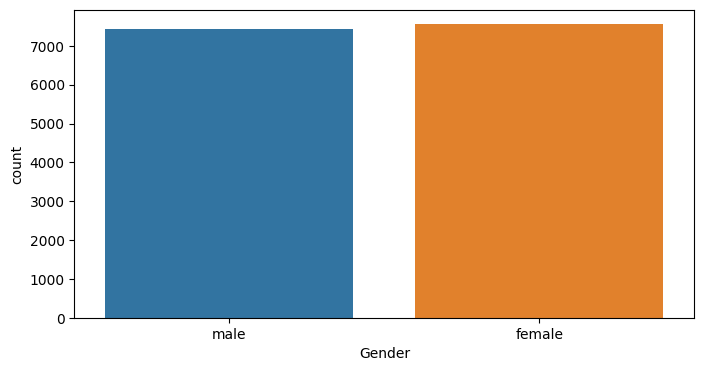

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x=df.Gender, hue=df.Gender)
plt.show()

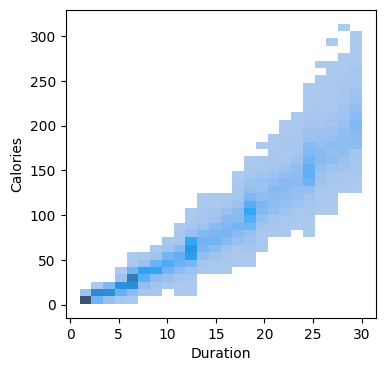

In [9]:
plt.figure(figsize=(4,4))
sns.histplot(x=df.Duration, y=df.Calories)
plt.show()

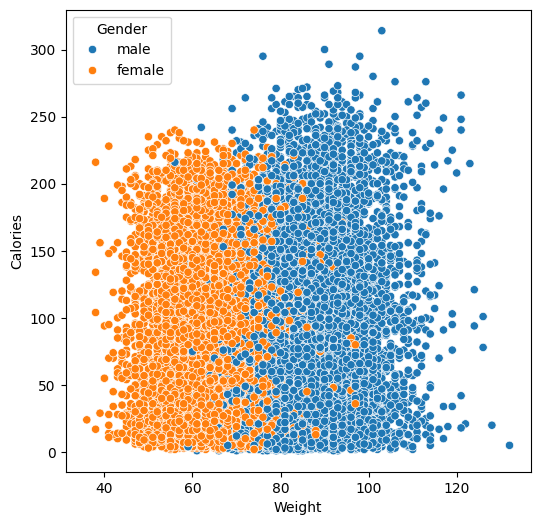

In [10]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=df.Weight, y=df.Calories, hue=df.Gender)
plt.show()

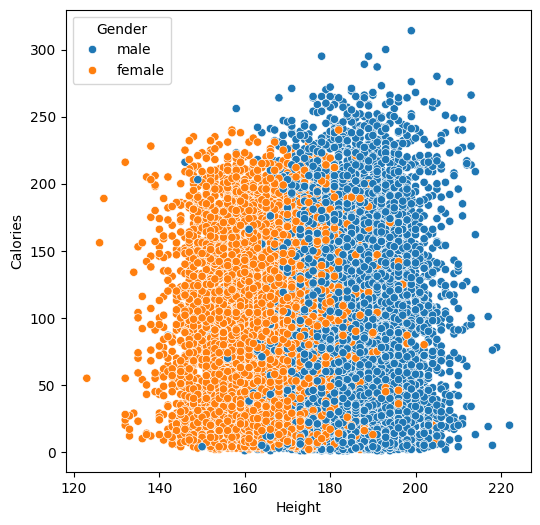

In [11]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=df.Height, y=df.Calories, hue=df.Gender)
plt.show()

<Figure size 400x400 with 0 Axes>

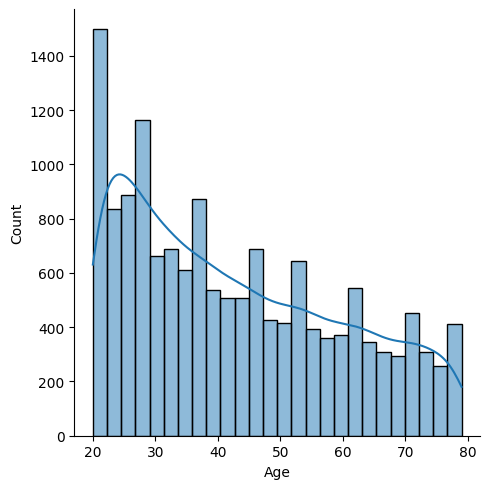

In [12]:
plt.figure(figsize=(4,4))
sns.displot(x=df.Age, kde=True)
plt.show()

### PCA

In [13]:
pca_data = df.iloc[:,2:]
pca = PCA(n_components=2)
x_pca = pca.fit_transform(pca_data)

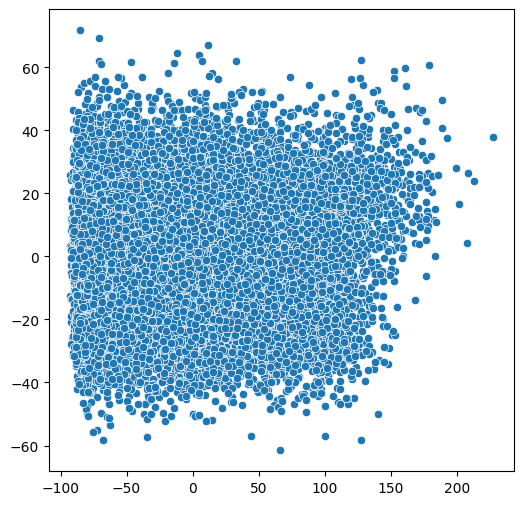

In [14]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1])
plt.show()

## preparation and cleaning

In [15]:
x_data = df.iloc[:,1:-1]
x_data = pd.get_dummies(x_data, columns=["Gender"])
y_data = df.iloc[:,-1:]

In [16]:
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(x_data,y_data)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_data.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(8,'Score'))  

           Specs         Score
3       Duration  63736.882215
4     Heart_Rate  11990.436329
0            Age   6213.761331
2         Weight   1782.146288
1         Height    574.729710
7    Gender_male    275.963044
6  Gender_female    272.090135
5      Body_Temp    202.785507


## custom dataset

In [17]:
r_x_data = x_data #reduced feature amount
r_x_data = r_x_data.drop(['Height', 'Gender_male','Gender_female','Body_Temp'], axis=1)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
r_x_train, r_x_test, r_y_train, r_y_test = train_test_split(r_x_data, y_data, test_size=0.2, random_state=42)

In [19]:
class CaloriesData(Dataset):
    def __init__(self,X, y):
        X = X.map(lambda x: int(x) if isinstance(x, bool) else x)
        X = (X-X.min())/(X.max()-X.min())
        self.X = X;
        self.y = y;
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.tensor(list(self.X.iloc[idx]))
        y = torch.tensor(list(self.y.iloc[idx]))
        return X, y

In [20]:
BATCH_SIZE = 32

#### Full dataset

In [21]:
f_train_Loader = DataLoader(CaloriesData(x_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
f_test_Loader = DataLoader(CaloriesData(x_test, y_test), batch_size=BATCH_SIZE, shuffle=True)

#### Reduced dataset

In [22]:
r_train_Loader = DataLoader(CaloriesData(r_x_train, r_y_train), batch_size=BATCH_SIZE, shuffle=True)
r_test_Loader = DataLoader(CaloriesData(r_x_test, r_y_test), batch_size=BATCH_SIZE, shuffle=True)

# Models preperation

## Initialize

### Multi layer Perceptron

In [23]:
class MLP(nn.Module):
    def __init__(self, in_features):
        super(MLP, self).__init__()
        torch.set_default_dtype(torch.float64)
        out_feat = 16
        if(in_features < 8):
            out_feat = 8
        self.linear1 = nn.Linear(in_features=in_features, out_features=out_feat)
        self.reLu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = out_feat, out_features=1)
        self.reLu2 = nn.ReLU()
        
    def forward(self, _x):
        x = self.linear1(_x)
        x = self.reLu1(x)
        x = self.linear2(x)
        x = self.reLu2(x)
        return x

In [24]:
featureSize_full = len(x_train.columns)
featureSize_reduced = len(r_x_train.columns)
featureSize_reduced

4

In [25]:
model_full = MLP(featureSize_full).to(device=device)
model_reduced = MLP(featureSize_reduced).to(device=device)

#### Train model with all features

In [26]:
NUM_EPOCHS = 100

loss_fn = nn.MSELoss()##nn.L1Loss()
optimizer = optim.SGD(model_full.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
loss_values_full = []
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for X, y in f_train_Loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        
        output = model_full(X)
        
        loss = loss_fn(output, y)
        
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
    
    avg_loss = total_loss / len(f_train_Loader)
    scheduler.step(avg_loss)
    loss_values_full.append(avg_loss)
    
    # print(f'Epoch {(epoch+1)}/{NUM_EPOCHS}, Loss: {round(avg_loss, 4)}')
    if ((epoch+1)%20)==0 :
        print(f'Epoch {(epoch+1)}/{NUM_EPOCHS}, Loss: {round(avg_loss, 4)}')
    elif (epoch+1) == 1:
        print(f'Epoch {(epoch+1)}/{NUM_EPOCHS}, Loss: {round(avg_loss, 4)}')
    

Epoch 1/100, Loss: 668.0156
Epoch 20/100, Loss: 9.6741
Epoch 40/100, Loss: 6.726
Epoch 60/100, Loss: 5.6681
Epoch 80/100, Loss: 5.0733
Epoch 100/100, Loss: 4.2465


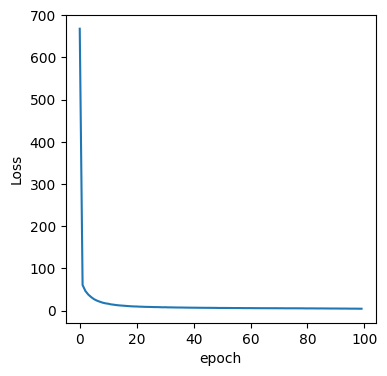

In [27]:
plt.figure(figsize=(4,4))
plot = sns.lineplot(loss_values_full)
plot.set(xlabel='epoch', ylabel='Loss')
plt.show()

#### Train model with selected features

In [28]:
NUM_EPOCHS = 100

loss_fn = nn.MSELoss()#nn.L1Loss() 
optimizer = optim.SGD(model_reduced.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
loss_values_reduced = []
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for X, y in r_train_Loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        
        output = model_reduced(X)
        
        loss = loss_fn(output, y)
        
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
    
    avg_loss = total_loss / len(r_train_Loader)
    scheduler.step(avg_loss)
    loss_values_reduced.append(avg_loss)
    
    # print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {round(avg_loss, 4)}')
    if ((epoch+1)%20)==0 :
        print(f'Epoch {(epoch+1)}/{NUM_EPOCHS}, Loss: {round(avg_loss, 4)}')
    elif (epoch+1) == 1:
        print(f'Epoch {(epoch+1)}/{NUM_EPOCHS}, Loss: {round(avg_loss, 4)}')
    

Epoch 1/100, Loss: 883.7668
Epoch 20/100, Loss: 38.3534
Epoch 40/100, Loss: 27.679
Epoch 60/100, Loss: 24.1797
Epoch 80/100, Loss: 22.6718
Epoch 100/100, Loss: 21.2443


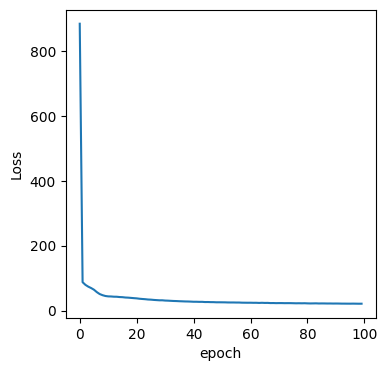

In [29]:
plt.figure(figsize=(4,4))
plot = sns.lineplot(loss_values_reduced)
plot.set(xlabel='epoch', ylabel='Loss')
plt.show()

### linear regression

In [30]:
linear_reg_full = LinearRegression().fit(x_train, y_train)
linear_reg_reduced = LinearRegression().fit(r_x_train, r_y_train)

### random forest

In [31]:
random_forest_full = RandomForestRegressor().fit(x_train, y_train)
random_forest_reduced = RandomForestRegressor().fit(r_x_train, r_y_train)

c:\Users\Abtin\anaconda3\envs\calorie_prediction\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Abtin\anaconda3\envs\calorie_prediction\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Model evaluation

### linear regression

#### Full dataset

In [32]:
pred_full = linear_reg_full.predict(x_train)
score_full = metrics.r2_score(y_train,pred_full)
score_full

0.9671621074066676

In [33]:
pred_full = linear_reg_full.predict(x_test)
score_full = metrics.r2_score(y_test,pred_full)
score_full

0.9672937151257295

#### Reduced dataset

In [34]:
pred_reduced = linear_reg_reduced.predict(r_x_train)
score_reduced = metrics.r2_score(r_y_train,pred_reduced)
score_reduced

0.9587675020329568

In [35]:
pred_reduced = linear_reg_reduced.predict(r_x_test)
score_reduced = metrics.r2_score(r_y_test,pred_reduced)
score_reduced

0.958871751091686

### random forest

#### Full dataset

In [36]:
pred_full = random_forest_full.predict(x_train)
score_full = metrics.r2_score(y_train,pred_full)
score_full

0.999690984413454

In [37]:
pred_full = random_forest_full.predict(x_test)
score_full = metrics.r2_score(y_test,pred_full)
score_full

0.9981971365201766

#### Reduced dataset

In [38]:
pred_reduced = random_forest_reduced.predict(r_x_train)
score_reduced = metrics.r2_score(r_y_train,pred_reduced)
score_reduced

0.9992393288983844

In [39]:
pred_reduced = random_forest_reduced.predict(r_x_test)
score_reduced = metrics.r2_score(r_y_test,pred_reduced)
score_reduced

0.99548103734692

### MLP

#### Full dataset

In [40]:
model_full.eval() 
all_preds = []
all_y = []
with torch.no_grad():
    for X, y in f_test_Loader:
        
        X = X.to(device)
        y = y.to(device)
        
        output = model_full(X)
        
        all_preds.extend(output.view(-1).cpu().numpy())
        all_y.extend(y.view(-1).cpu().numpy())
        
score_full = metrics.r2_score(all_y,all_preds)
score_full
        


0.9527159852001095

#### Reduced dataset

In [41]:
model_reduced.eval() 
all_preds = []
all_y = []
with torch.no_grad():
    for X, y in r_test_Loader:
        
        X = X.to(device)
        y = y.to(device)
        
        output = model_reduced(X)
        
        all_preds.extend(output.view(-1).cpu().numpy())
        all_y.extend(y.view(-1).cpu().numpy())
        
score_reduced = metrics.r2_score(all_y,all_preds)
score_reduced
        


0.9505394896868085

# Playground

In [65]:
example_val_full = x_test.iloc[0]
print(example_val_full)
example_val_full = example_val_full.values.reshape(1,-1)
pred_calories = random_forest_full.predict(example_val_full)
print(f'Burned calories (prediction): {pred_calories[0]}')
print(f'Burned calories (actual): {y_test.iloc[0].values[0]}')

Age                 45
Height           154.0
Weight            52.0
Duration          26.0
Heart_Rate       107.0
Body_Temp         40.6
Gender_female     True
Gender_male      False
Name: 11499, dtype: object
Burned calories (prediction): 170.31
Burned calories (actual): 173.0


c:\Users\Abtin\anaconda3\envs\calorie_prediction\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [66]:
example_val_reduced = r_x_test.iloc[0]
print(example_val_reduced)
example_val_reduced = example_val_reduced.values.reshape(1, -1)
pred_calories = random_forest_reduced.predict(example_val_reduced)
print(f'Burned calories (prediction): {pred_calories[0]}')
print(f'Burned calories (actual): {r_y_test.iloc[0].values[0]}')

Age            45.0
Weight         52.0
Duration       26.0
Heart_Rate    107.0
Name: 11499, dtype: float64
Burned calories (prediction): 170.41
Burned calories (actual): 173.0


c:\Users\Abtin\anaconda3\envs\calorie_prediction\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [92]:
age = 23
weight = 92
duration = 60
heart_rate = 110

In [93]:
self_values = np.array([[age,weight,duration,heart_rate]])
burned_cal = random_forest_reduced.predict(self_values)
print(f'age: {age}')
print(f'weight: {weight}')
print(f'duration: {duration}')
print(f'heart_rate: {heart_rate}')
print(f'burned calories: {burned_cal[0]}')



age: 23
weight: 92
duration: 60
heart_rate: 110
burned calories: 192.15


c:\Users\Abtin\anaconda3\envs\calorie_prediction\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
